In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [43]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler 
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

In [ ]:
df = pd.read_excel('Online_Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [46]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [47]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


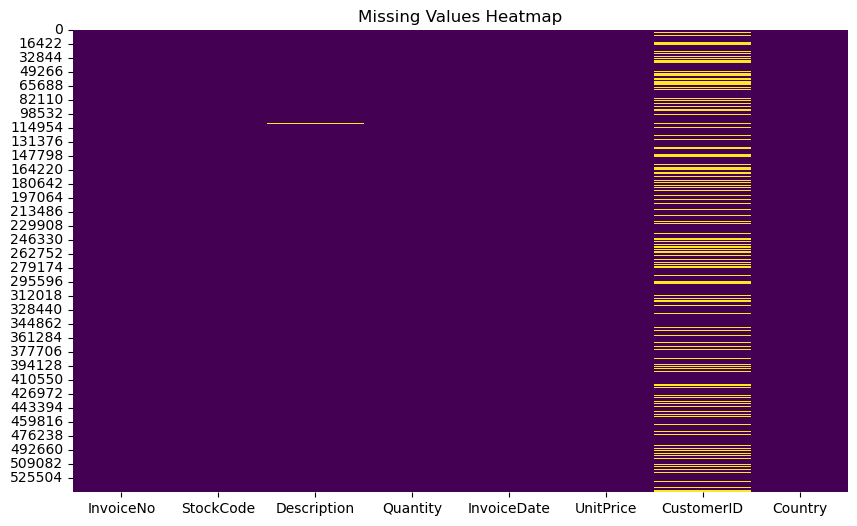

In [48]:
plt.figure(figsize=(10,6))
sns.heatmap(df.isnull(), cmap='viridis', cbar=False)
plt.title('Missing Values Heatmap')
plt.show()

In [49]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [50]:
# Identify numerical and categorical columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

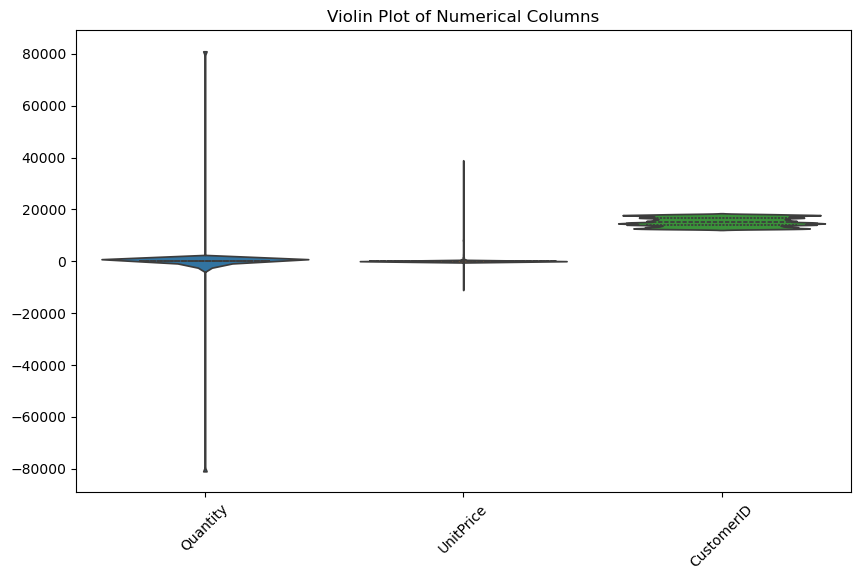

In [51]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=df[num_cols], inner="quartile")
plt.xticks(rotation=45)
plt.title("Violin Plot of Numerical Columns")
plt.show()

In [52]:
# Step 1: Handle Missing Values
df = df.dropna(subset=['CustomerID'])  # Drop rows with missing CustomerID
df = df.drop(columns=['Description'])  # Remove unnecessary text column

In [53]:
# There are some negative values in Quantity and Unit price Handling it

# Step 2: Remove Cancellations (Negative Quantities)
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]  # Ensure valid transactions

In [54]:
# # Step 3: Remove Outliers using IQR Method
# def remove_outliers(df, col):
#     Q1 = df[col].quantile(0.25)
#     Q3 = df[col].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
#     return df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

# df = remove_outliers(df, 'Quantity')
# df = remove_outliers(df, 'UnitPrice')

In [55]:
# Step 4: Calculate Total Spending per Transaction
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [56]:
# Step 5: Aggregate Data by CustomerID for Clustering
customer_data = df.groupby('CustomerID').agg({
    'TotalPrice': 'sum',      # Total spending
    'Quantity': 'sum',        # Total items purchased
    'InvoiceNo': 'nunique'    # Number of transactions
}).rename(columns={'InvoiceNo': 'NumTransactions'})

In [57]:
# Log transform to reduce skewness (adding 1 to avoid log(0))
customer_data[['TotalPrice', 'Quantity']] = np.log1p(customer_data[['TotalPrice', 'Quantity']])

In [58]:
# Step 7: Scale the Data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(customer_data)

In [59]:
print("Preprocessed Data Shape:", X_scaled.shape)
customer_data.head()

Preprocessed Data Shape: (4338, 3)


,TotalPrice,Quantity,NumTransactions
CustomerID,,,
12346.0,11.253955,11.214735,1
12347.0,8.368925,7.807510,7
12348.0,7.494564,7.758761,4
12349.0,7.472245,6.448889,1
12350.0,5.815324,5.288267,1


# Clustering with Random Value of "K"

         TotalPrice   Quantity  NumTransactions
Cluster                                        
0          5.184541   4.411906         1.284167
1          7.797363   7.275963         6.318374
2         10.774052  10.306704       121.750000
3          6.442695   5.888930         2.410431
4          9.307641   8.705375        23.259459


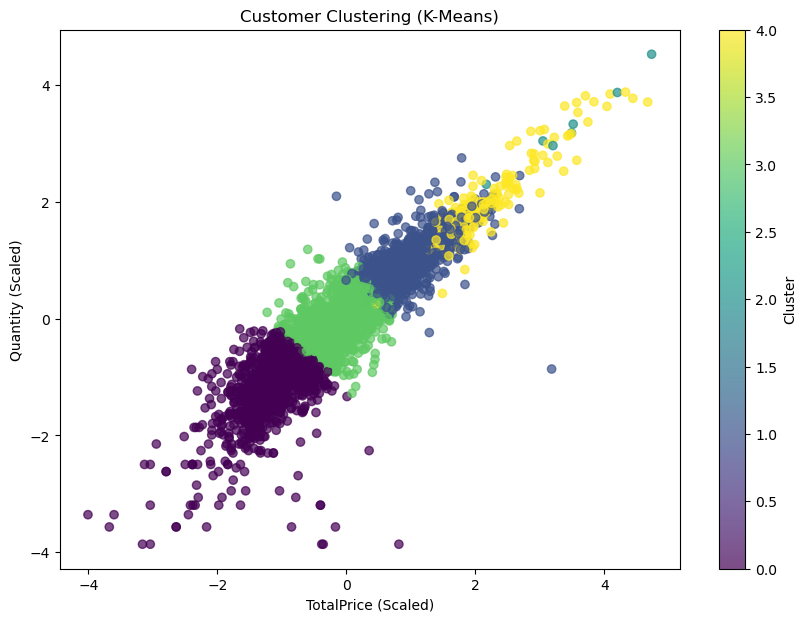

In [60]:
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
customer_data['Cluster'] = kmeans.fit_predict(X_scaled)

# Step 3: Analyze Cluster Characteristics
print(customer_data.groupby('Cluster').mean())

# Step 4 (Optional): Scatter Plot for Visualization (Only for 2D Projection)
plt.figure(figsize=(10, 7))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=customer_data['Cluster'], cmap='viridis', alpha=0.7)
plt.xlabel("TotalPrice (Scaled)")
plt.ylabel("Quantity (Scaled)")
plt.title("Customer Clustering (K-Means)")
plt.colorbar(label="Cluster")
plt.show()

# Analysis
- By using random value of k the clustesring we get is irregular and clusters are not identified perfectly.

# Using Elbow Method to find value of 'K'

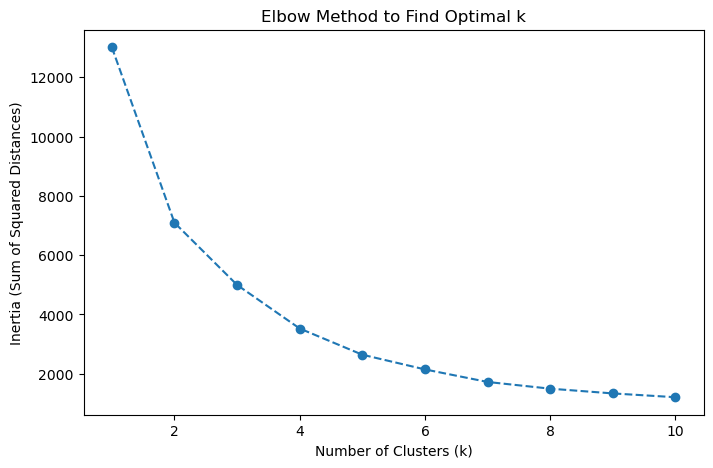

In [61]:
from sklearn.cluster import KMeans

# Step 1: Find the optimal number of clusters using Elbow Method
inertia = []
K_range = range(1, 11)  # Checking for k = 1 to 10

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o', linestyle='--')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Sum of Squared Distances)")
plt.title("Elbow Method to Find Optimal k")
plt.show()

         TotalPrice  Quantity  NumTransactions  DBSCAN_Cluster
Cluster                                                       
0          5.809018  5.153703         1.774096        0.004142
1          7.832582  7.300823         8.216409       -0.027348


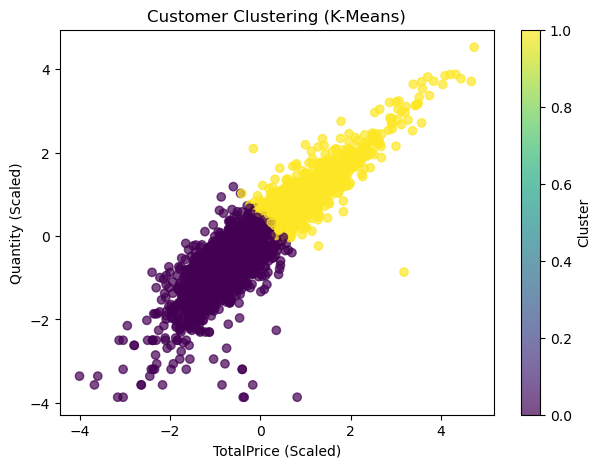

In [86]:
# Step 2: Apply K-Means with the chosen k (let's assume k=4 based on elbow method)
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
customer_data['Cluster'] = kmeans.fit_predict(X_scaled)

# Step 3: Analyze Cluster Characteristics
print(customer_data.groupby('Cluster').mean())

# Step 4 (Optional): Scatter Plot for Visualization (Only for 2D Projection)
plt.figure(figsize=(7,5))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=customer_data['Cluster'], cmap='viridis', alpha=0.7)
plt.xlabel("TotalPrice (Scaled)")
plt.ylabel("Quantity (Scaled)")
plt.title("Customer Clustering (K-Means)")
plt.colorbar(label="Cluster")
plt.show()

# Analysis:
- Using elbow method and taking k=2 gives us categories we want but there is clear noise 'outliers' and K-means is senstive to it so this is a pitfall of K means that first remove outliers then use k mean clustering.

# Conclusion
The clustering shows two groups: **regular customers (low spending, dark purple)** and **high-spending customers (bulk buyers, yellow)**. A strong correlation exists between spending and quantity purchased. Businesses can **target high-value customers with personalized deals** and **encourage regular buyers to spend more through loyalty programs**.

# DB SCAN

In [83]:
customer_data.head()

,TotalPrice,Quantity,NumTransactions,Cluster,DBSCAN_Cluster
CustomerID,,,,,
12346.0,11.253955,11.214735,1,-1,-1
12347.0,8.368925,7.807510,7,0,0
12348.0,7.494564,7.758761,4,0,0
12349.0,7.472245,6.448889,1,0,0
12350.0,5.815324,5.288267,1,0,0


Number of clusters (excluding noise): 4
Noise points (Cluster -1): 59


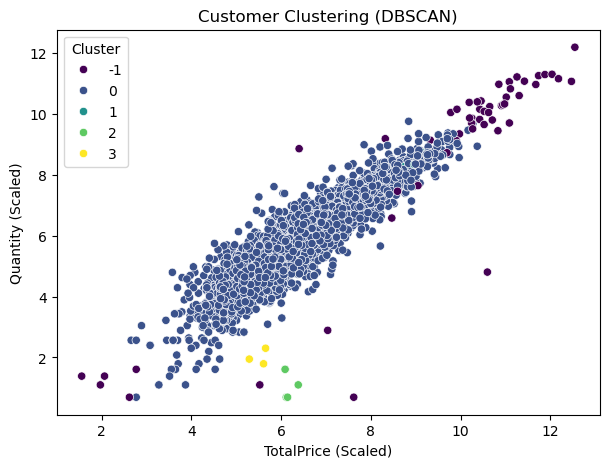

DBSCAN_Cluster
 0    4266
-1      59
 1       5
 2       5
 3       3
Name: count, dtype: int64


In [85]:
# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)  # eps and min_samples may need tuning
customer_data['DBSCAN_Cluster'] = dbscan.fit_predict(X_scaled)

# Analyze DBSCAN results
print("Number of clusters (excluding noise):", len(set(customer_data['DBSCAN_Cluster'])) - 1)
print("Noise points (Cluster -1):", (customer_data['DBSCAN_Cluster'] == -1).sum())

# Plot results
plt.figure(figsize=(7,5))
sns.scatterplot(x=customer_data['TotalPrice'], y=new_customer_data['Quantity'], hue=customer_data['DBSCAN_Cluster'], palette="viridis")
plt.title("Customer Clustering (DBSCAN)")
plt.xlabel("TotalPrice (Scaled)")
plt.ylabel("Quantity (Scaled)")
plt.legend(title="Cluster")
plt.show()

# Count customers in each cluster
print(customer_data['DBSCAN_Cluster'].value_counts())

K-Means Silhouette Score: 0.495

K-Means Cluster Counts:
 Cluster
0    2656
1    1682
Name: count, dtype: int64

DBSCAN Cluster Counts:
 DBSCAN_Cluster
 0    4266
-1      59
 1       5
 2       5
 3       3
Name: count, dtype: int64


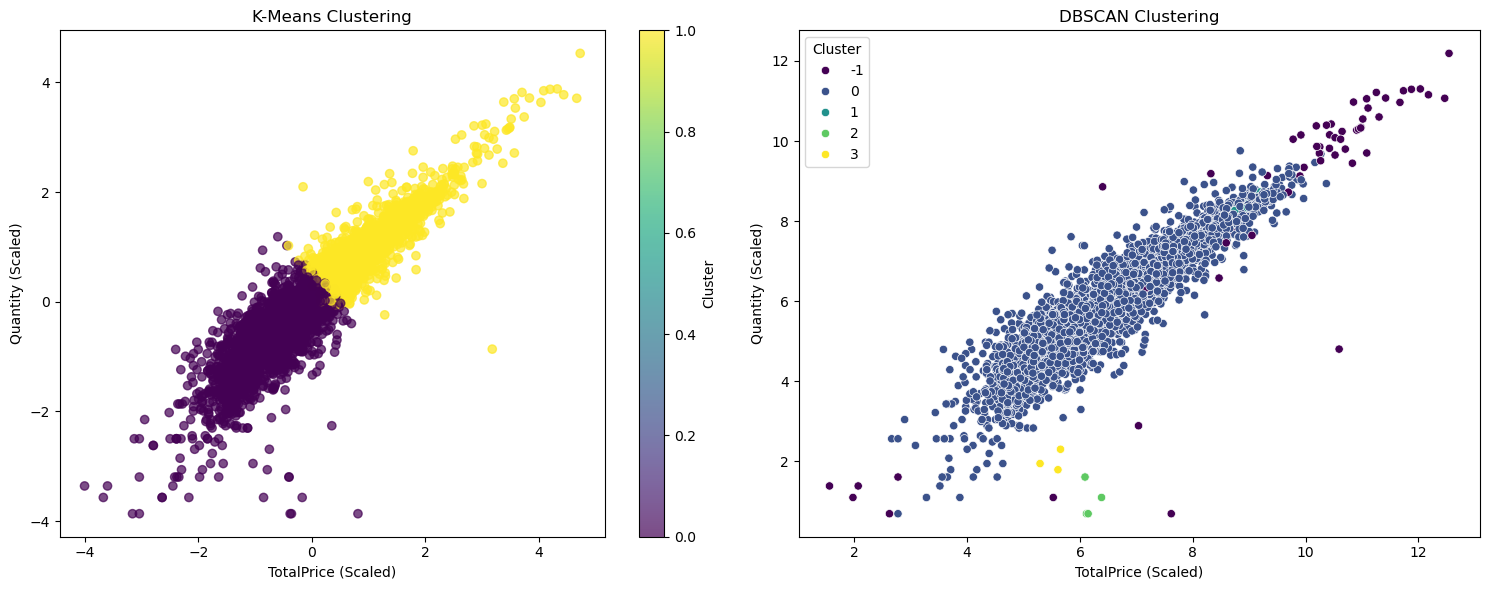

In [101]:
from sklearn.metrics import silhouette_score

# Silhouette score (only for K-Means)
kmeans_silhouette = silhouette_score(X_scaled, customer_data['Cluster'])
print(f"K-Means Silhouette Score: {kmeans_silhouette:.3f}")

# Count of points per cluster
print("\nK-Means Cluster Counts:\n", customer_data['Cluster'].value_counts())
print("\nDBSCAN Cluster Counts:\n", customer_data['DBSCAN_Cluster'].value_counts())

# Creating subplots for side-by-side visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# K-Means clustering visualization
sc = ax1.scatter(X_scaled[:, 0], X_scaled[:, 1], c=customer_data['Cluster'], cmap='viridis', alpha=0.7)
ax1.set_title('K-Means Clustering')
ax1.set_xlabel("TotalPrice (Scaled)")
ax1.set_ylabel("Quantity (Scaled)")
fig.colorbar(sc, ax=ax1, label="Cluster")  # Attach colorbar to ax1

# DBSCAN clustering visualization
sns.scatterplot(x=customer_data['TotalPrice'], y=customer_data['Quantity'], hue=customer_data['DBSCAN_Cluster'], palette="viridis", ax=ax2)
ax2.set_title('DBSCAN Clustering')
ax2.set_xlabel("TotalPrice (Scaled)")
ax2.set_ylabel("Quantity (Scaled)")
ax2.legend(title="Cluster")

# Show the final figure (prevents empty extra plots)
plt.tight_layout()
plt.show()


### **Conclusion & Comparison**  
- **K-Means** formed **2 distinct clusters**, as shown by the yellow and purple regions, with a **moderate silhouette score of 0.495**, indicating well-separated clusters. However, it assumes spherical clusters, which may not always be ideal.  
- **DBSCAN**, on the other hand, identified **multiple small clusters (1, 2, and 3)** along with a large main cluster (0) and some noise points (-1). This method is better at handling outliers but is sensitive to parameter tuning.  
- While **K-Means provides clear segmentation**, **DBSCAN is more flexible for detecting anomalies** but struggles with dense, continuous data distributions like this one.